**Importing all required libraries.**

In [1]:
import ssl
import nltk

# Disable SSL certificate verification temporarily
ssl._create_default_https_context = ssl._create_unverified_context

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('wordnet', quiet=True)

# Reset SSL context to default for safety
ssl._create_default_https_context = ssl.create_default_context


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sanjna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
import gensim
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Loading the dataset.**

In [3]:
df = pd.read_csv('combined_file.csv')

**Task 1: Topic Modeling.**


**1. Preprocess the data.**

In [4]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, text):
       #Converting to lowercase.
        text = text.lower()
        #Removing mentions and URLs.
        text = re.sub(r'(@\w+|http\S+|www\S+|https\S+)', '', text)
        #Removing hashtags, special characters and numbers.
        text = re.sub(r'[^\w\s]', '', text)
        #Removing extra spaces.
        text = re.sub(r'\s+', ' ', text).strip()
        # Tokenizing text.
        tokens = word_tokenize(text)
        # Removing stopwords and lemmatize tokens.
        cleaned_tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens if token not in self.stop_words
        ]
        # Joining tokens back into a single string.
        return ' '.join(cleaned_tokens)

# Example usage:
if __name__ == "__main__":
    processor = TextPreprocessor()
    # Applying preprocessing to each row.
    df['cleaned_text'] = df['text'].apply(TextPreprocessor().preprocess)

**Comparing original and cleaned text for few rows.**

In [ ]:
for original, cleaned in zip(df['text'].head(), df['cleaned_text'].head()):
    print(f"Original: {original}")
    print(f"Cleaned: {cleaned}")
    print("-" * 100)

Original: Don’t message me if you can’t live verify. Too many scammers out there trying to fool me.
Cleaned: dont message cant live verify many scammer trying fool
----------------------------------------------------------------------------------------------------
Original: Salaam everyone. I’m a F currently going through a divorce and I’ve been making Istikhara to see if this decision is right for me. There’s so many “what-if’s” in my mind. What if I miss my husband again? What if I realize this was a huge mistake? What if he finds someone but I’m stuck with regret? Divorce is truly a confusing time. Sometimes I wish I could ask God and get a direct verbal answer from Him but that’s not possible, so I’ve been praying Istikhara for guidance and clarity. In the meantime, I’d love to know some of your Istikhara success stories. What are some moments you felt extremely stuck and confused but Allah sent you a sign or gave you a miracle of clarity? What is some advice you’d give me to navig

**2. Apply LDA (Latent Dirichlet Allocation) for Topic Modeling.**

In [ ]:
class LDATopicModeler:
    def __init__(self, cleaned_texts, max_features=1000):
        self.cleaned_texts = cleaned_texts
        self.max_features = max_features
        self.vectorizer = None
        self.doc_term_matrix = None
        self.dictionary = None
        self.corpus = None

    # Step 1: Vectorizing the cleaned text using CountVectorizer.
    def vectorize_text(self):
        self.vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=self.max_features, stop_words='english')
        self.doc_term_matrix = self.vectorizer.fit_transform(self.cleaned_texts)
        return self.doc_term_matrix

    def build_corpus(self):
        # Step 2: Tokenizing the cleaned texts and build gensim dictionary and corpus.
        tokenized_texts = [text.split() for text in self.cleaned_texts]
        self.dictionary = gensim.corpora.Dictionary(tokenized_texts)
        self.corpus = [self.dictionary.doc2bow(text) for text in tokenized_texts]

    # Step 3: Applying LDA and calculate coherence score.
    def lda_with_coherence(self, start=1, end=10):
        coherence_scores = []
        self.build_corpus()
        for n_topics in range(start, end + 1):
            lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda_model.fit(self.doc_term_matrix)
            topic_words = self.get_topic_words(lda_model, 10)
            coherence = self.compute_coherence(topic_words)
            coherence_scores.append((n_topics, coherence))
            print(f"Number of Topics: {n_topics}, Coherence Score: {coherence:.4f}")
        return coherence_scores

    # Step 4: Helper to get top words for each topic.
    def get_topic_words(self, lda_model, n_top_words):
        words = self.vectorizer.get_feature_names_out()
        topics = []
        for topic_idx, topic in enumerate(lda_model.components_):
            topic_top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            topics.append(topic_top_words)
        return topics

    # Step 5: Compute coherence.
    def compute_coherence(self, topics):
        coherence_model = CoherenceModel(topics=topics, texts=[text.split() for text in self.cleaned_texts],
                                         dictionary=self.dictionary, coherence='c_v')
        return coherence_model.get_coherence()

    # Step 6: Finding best topic number, coherence, and selecting the number of topics with the highest coherence.
    def find_best_topic_number(self, start=1, end=10):
        self.vectorize_text()
        coherence_scores = self.lda_with_coherence(start, end)
        best_topic = max(coherence_scores, key=lambda x: x[1])
        print(f"Optimal Number of Topics: {best_topic[0]} with Coherence Score: {best_topic[1]:.4f}")
        #return best_topic
         # Fitting LDA with optimal number of topics.
        optimal_lda_model = LatentDirichletAllocation(n_components=best_topic[0], random_state=24)
        optimal_lda_model.fit(self.doc_term_matrix)

        # Displaying the topics.
        self.display_topics(optimal_lda_model, 10)
        return optimal_lda_model, best_topic

    #Displaying the top words for each topic.
    def display_topics(self, lda_model, n_top_words=10):
        words = self.vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda_model.components_):
            top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# Example Usage
if __name__ == "__main__":
    #'cleaned_texts' is a list of preprocessed text.
    cleaned_texts = df['cleaned_text'].tolist()
    lda_modeler = LDATopicModeler(cleaned_texts)
    lda_modeler.find_best_topic_number(start=1, end=10)

Number of Topics: 1, Coherence Score: 0.4173
Number of Topics: 2, Coherence Score: 0.6500
Number of Topics: 3, Coherence Score: 0.6253
Number of Topics: 4, Coherence Score: 0.6021
Number of Topics: 5, Coherence Score: 0.6201
Number of Topics: 6, Coherence Score: 0.6315
Number of Topics: 7, Coherence Score: 0.6086
Number of Topics: 8, Coherence Score: 0.6051
Number of Topics: 9, Coherence Score: 0.6156
Number of Topics: 10, Coherence Score: 0.5791
Optimal Number of Topics: 2 with Coherence Score: 0.6500
Topic #1: im, like, know, dont, muslim, want, allah, time, feel, people
Topic #2: israel, people, palestinian, hamas, israeli, gaza, jew, war, palestine, jewish


**3. Label the Topics.**

Assigning labels to the topics.


Topic 1: Personal Experiences and Feelings (words like "im," "feel," "time","people").
Topic 2: Conflict and Politics (words like "israel," "palestinian," "hamas," "war").

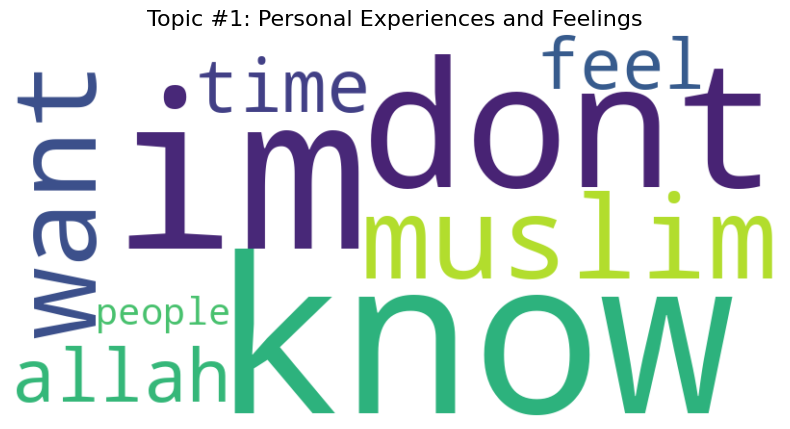

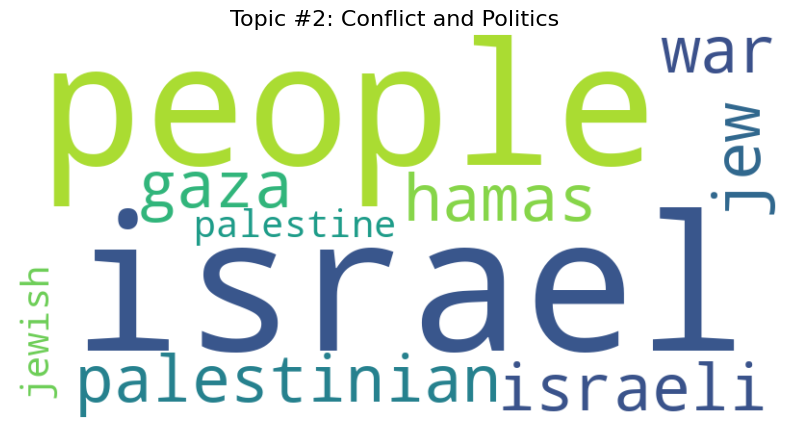

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class TopicVisualizer:
    def __init__(self, topics, labels):
        #param topics: List of topics with top words.
        #param labels: List of assigned labels for each topic.
        self.topics = topics
        self.labels = labels

    def generate_word_clouds(self):
        #Generating word clouds for each topic.
        for idx, topic in enumerate(self.topics):
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(topic))
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Topic #{idx+1}: {self.labels[idx]}", fontsize=16)
            plt.show()

# Example usage:
if __name__ == "__main__":
    # Topics and labels based on output.
    topics = [
        #Topic 1
        ["im", "like", "know", "dont", "muslim", "want", "allah", "time", "feel", "people"],
        #Topic 2
        ["israel", "people", "palestinian", "hamas", "israeli", "gaza", "jew", "war", "palestine", "jewish"]  # Topic 2
    ]
    labels = ["Personal Experiences and Feelings", "Conflict and Politics"]

    visualizer = TopicVisualizer(topics, labels)
    visualizer.generate_word_clouds()


**Task 2: Named Entity Recognition (NER).**

**1. NER Extraction using spaCy.**

**Installing.**

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from nltk import pos_tag, word_tokenize, sent_tokenize
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

**Loadinging NLTK VADER.**

In [ ]:
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')

# Loading the dataset
df = pd.read_csv('combined_file.csv')
text = df['text']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**Initializing sentiment analyzer.**

In [ ]:
#Sentiment Analysis using VADER.
vader_analyzer = SentimentIntensityAnalyzer()

**Defining entities.**

In [ ]:
entities_to_analyze = ["Israel", "Hamas", "Antony Blinken", "Benjamin Netanyahu", "Netanyahu", "IDF", "Israeli Defense Forces"]


**Data structures to hold results.**

In [ ]:
entity_sentiment_scores = defaultdict(list)
entity_pos_tags = defaultdict(lambda: defaultdict(list))

**2. Interpretation of Results.**

**POS Tagging.**

In [ ]:
# Function to analyze texts.
def analyze_texts(texts):
    for doc in texts:
        # Cleaning extra spaces.
        cleaned_text = re.sub(r'\s+', ' ', doc).strip()
        # Tokenizing into sentences
        sentences = sent_tokenize(cleaned_text)

        for sentence in sentences:
            for entity in entities_to_analyze:
                if entity.lower() in sentence.lower():
                    # Sentiment analysis
                    sentiment_score = vader_analyzer.polarity_scores(sentence)['compound']
                    entity_sentiment_scores[entity].append(sentiment_score)

                    # POS tagging
                    tokens = word_tokenize(sentence)
                    pos_tags = pos_tag(tokens)
                    for word, pos in pos_tags:
                        if pos.startswith('NN'):
                            entity_pos_tags[entity]['nouns'].append(word)
                        elif pos.startswith('VB'):
                            entity_pos_tags[entity]['verbs'].append(word)
                        elif pos.startswith('JJ'):
                            entity_pos_tags[entity]['adjectives'].append(word)

# Performing analysis.
analyze_texts(text)

In [ ]:
# Calculating and displaying average sentiment scores.
avg_sentiment_results = {
    entity: sum(scores) / len(scores) if scores else 0
    for entity, scores in entity_sentiment_scores.items()
}

# Displaying results.
print("\n=== Entity Sentiment Summary ===\n")
print(f"{'Entity':<25} | {'Average Sentiment Score':>25}")
print("-" * 55)
for entity, avg_score in avg_sentiment_results.items():
    print(f"{entity:<25} | {avg_score:>25.4f}")
print("\n" + "=" * 55)


=== Entity Sentiment Summary ===

Entity                    |   Average Sentiment Score
-------------------------------------------------------
Israel                    |                   -0.1126
Netanyahu                 |                   -0.1003
IDF                       |                   -0.1987
Hamas                     |                   -0.1906
Benjamin Netanyahu        |                   -0.1550
Israeli Defense Forces    |                   -0.1534
Antony Blinken            |                   -0.1039



Visualization of Sentiment Distribution per Entity and

In [ ]:
#Visualization 1: Sentiment Distribution per Entity
def plot_sentiment_distribution():
    sentiment_data = []
    for entity, scores in entity_sentiment_scores.items():
        for score in scores:
            sentiment_data.append({"Entity": entity, "Sentiment Score": score})
    sentiment_df = pd.DataFrame(sentiment_data)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Entity", y="Sentiment Score", data=sentiment_df)
    plt.title("Sentiment Score Distribution per Entity", fontsize=16)
    plt.xticks(rotation=45)
    plt.show()

# Visualization 2: POS Tag Count per Entity
def plot_pos_tag_counts():
    pos_data = []
    for entity, pos_tags in entity_pos_tags.items():
        for tag_type, words in pos_tags.items():
            pos_data.append({"Entity": entity, "POS Tag": tag_type, "Count": len(words)})

    pos_df = pd.DataFrame(pos_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(x="Entity", y="Count", hue="POS Tag", data=pos_df)
    plt.title("POS Tag Counts per Entity", fontsize=16)
    plt.xticks(rotation=45)
    plt.show()

**Word Cloud Visualization.**


Generating Visualizations:
Word Cloud for Israel


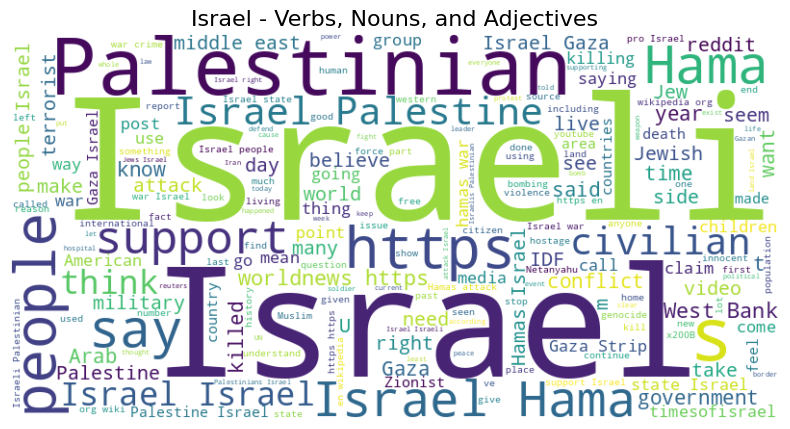

Word Cloud for Hamas


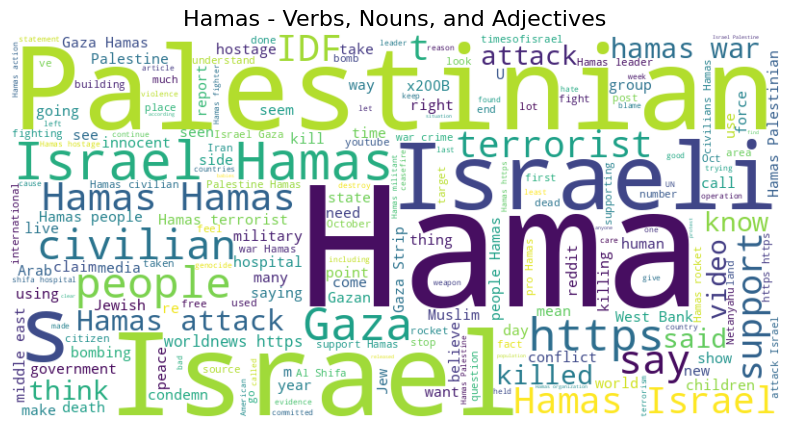

Word Cloud for Antony Blinken


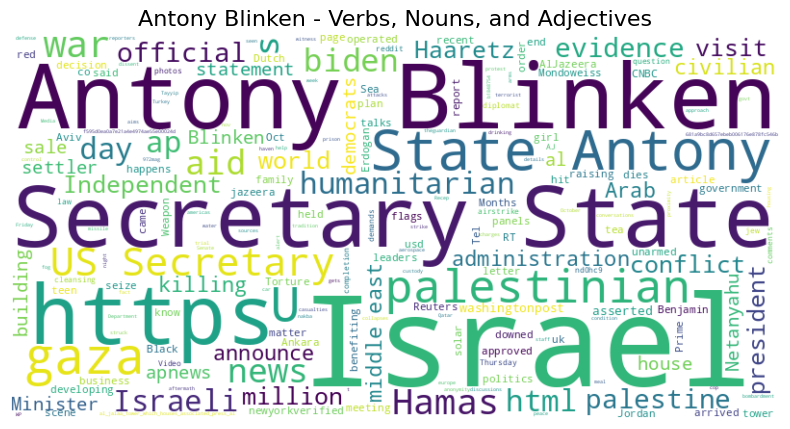

Word Cloud for Benjamin Netanyahu


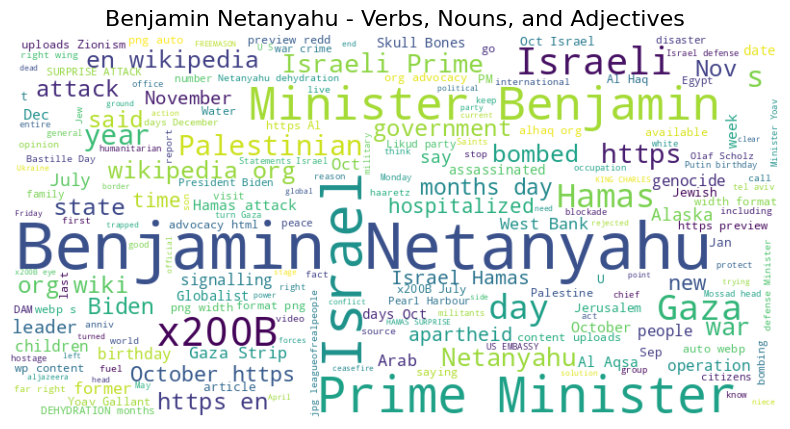

Word Cloud for Netanyahu


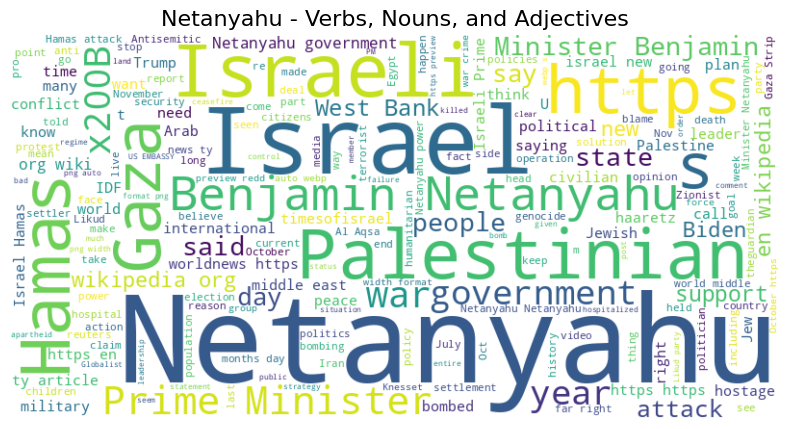

Word Cloud for IDF


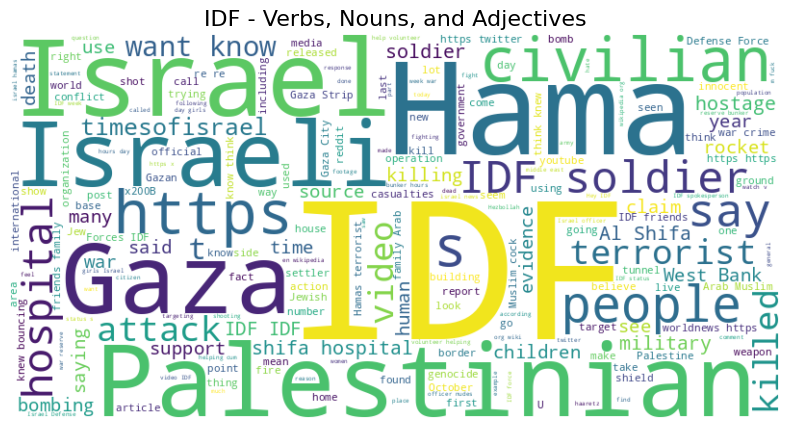

Word Cloud for Israeli Defense Forces


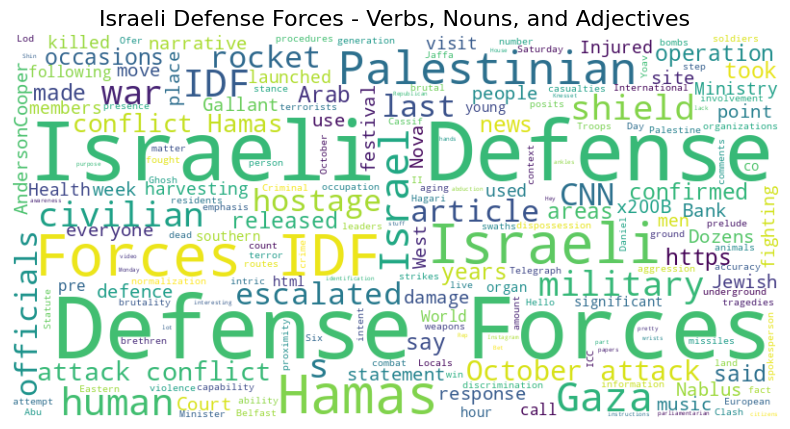

In [ ]:
# Function to generate word clouds.
def generate_wordcloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


# Generating word clouds
print("\nGenerating Visualizations:")
for entity in entities_to_analyze:
    print(f"Word Cloud for {entity}")
    words_combined = (
        entity_pos_tags[entity]['nouns'] +
        entity_pos_tags[entity]['verbs'] +
        entity_pos_tags[entity]['adjectives']
    )
    generate_wordcloud(words_combined, f"{entity} - Verbs, Nouns, and Adjectives")

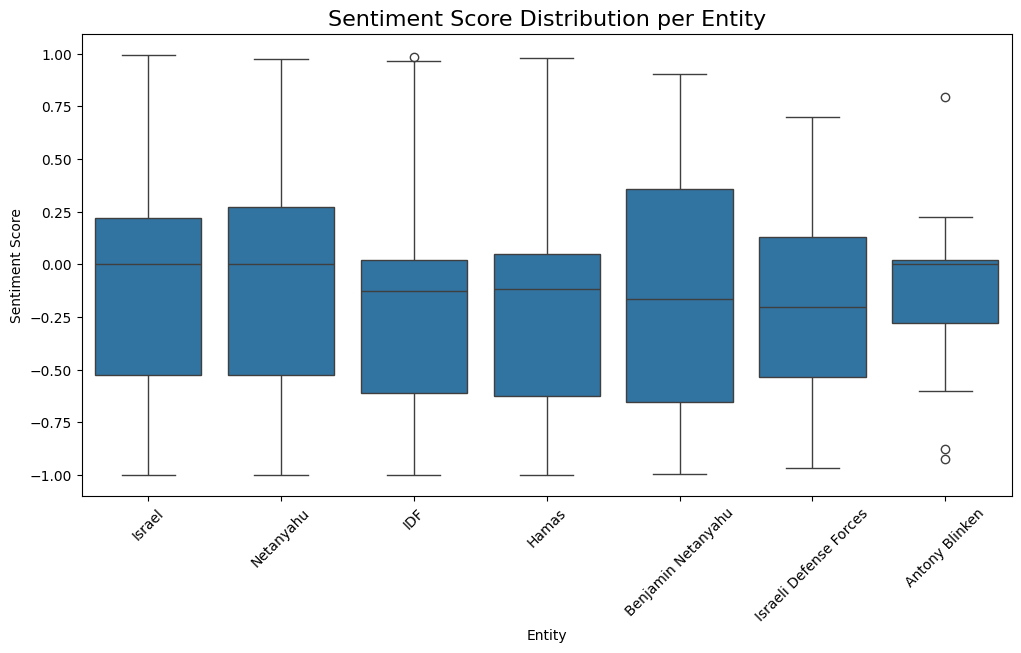

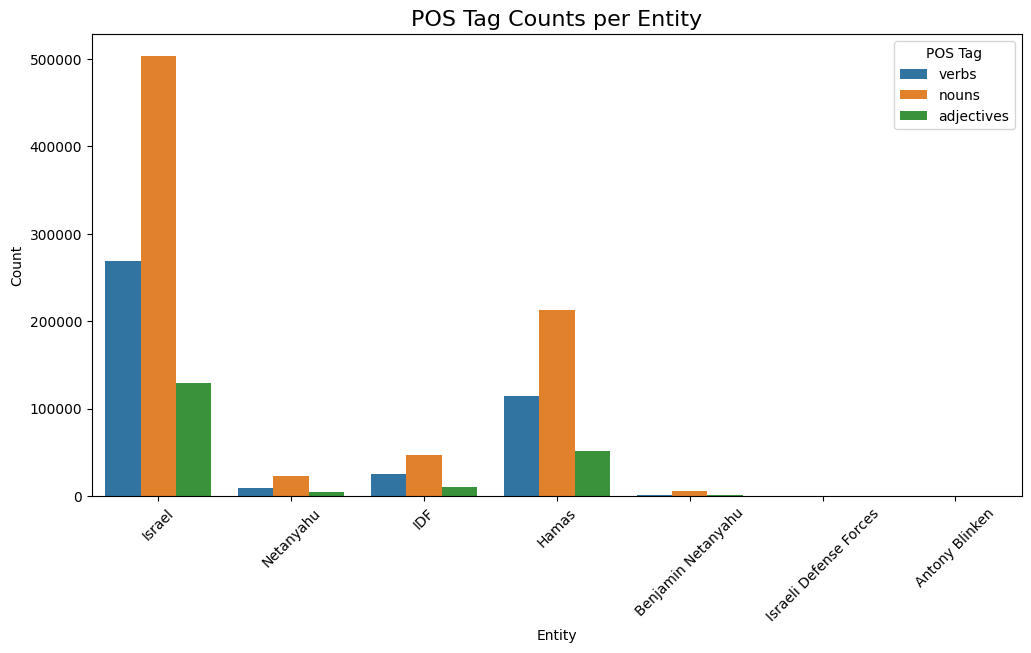

In [ ]:
# Calling visualizations .
plot_sentiment_distribution()
plot_pos_tag_counts()

**Task 3: Predicting Score for Each Reddit Post.**

**Importing all required libraries.**

In [4]:
%pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

In [9]:
# Loading dataset.
df = pd.read_csv('combined_file.csv')

# Combining title and text for better context.
df['combined_text'] = df['title'] + " " + df['text']

# Preprocess the combined text
df['cleaned_text'] = df['combined_text'].apply(lambda x: re.sub(r'\W+', ' ', x.lower().strip()))


**Feature Selection.**

In [10]:
class LDATopicModeler:
    def __init__(self, cleaned_texts, max_features=1000):
        self.cleaned_texts = cleaned_texts
        self.max_features = max_features
        self.vectorizer = None
        self.doc_term_matrix = None
        self.dictionary = None
        self.corpus = None

    # Step 1: Vectorizing the cleaned text using CountVectorizer.
    def vectorize_text(self):
        self.vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=self.max_features, stop_words='english')
        self.doc_term_matrix = self.vectorizer.fit_transform(self.cleaned_texts)
        return self.doc_term_matrix

    def build_corpus(self):
        # Step 2: Tokenizing the cleaned texts and build gensim dictionary and corpus.
        tokenized_texts = [text.split() for text in self.cleaned_texts]
        self.dictionary = gensim.corpora.Dictionary(tokenized_texts)
        self.corpus = [self.dictionary.doc2bow(text) for text in tokenized_texts]

    # Step 3: Applying LDA and calculate coherence score.
    def lda_with_coherence(self, start=1, end=10):
        coherence_scores = []
        self.build_corpus()
        for n_topics in range(start, end + 1):
            lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda_model.fit(self.doc_term_matrix)
            topic_words = self.get_topic_words(lda_model, 10)
            coherence = self.compute_coherence(topic_words)
            coherence_scores.append((n_topics, coherence))
            print(f"Number of Topics: {n_topics}, Coherence Score: {coherence:.4f}")
        return coherence_scores

    # Step 4: Helper to get top words for each topic.
    def get_topic_words(self, lda_model, n_top_words):
        words = self.vectorizer.get_feature_names_out()
        topics = []
        for topic_idx, topic in enumerate(lda_model.components_):
            topic_top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            topics.append(topic_top_words)
        return topics

    # Step 5: Compute coherence.
    def compute_coherence(self, topics):
        coherence_model = CoherenceModel(topics=topics, texts=[text.split() for text in self.cleaned_texts],
                                         dictionary=self.dictionary, coherence='c_v')
        return coherence_model.get_coherence()

    # Step 6: Finding best topic number, coherence, and selecting the number of topics with the highest coherence.
    def find_best_topic_number(self, start=1, end=10):
        self.vectorize_text()
        coherence_scores = self.lda_with_coherence(start, end)
        best_topic = max(coherence_scores, key=lambda x: x[1])
        print(f"Optimal Number of Topics: {best_topic[0]} with Coherence Score: {best_topic[1]:.4f}")
        #return best_topic
         # Fitting LDA with optimal number of topics.
        optimal_lda_model = LatentDirichletAllocation(n_components=best_topic[0], random_state=24)
        optimal_lda_model.fit(self.doc_term_matrix)

        # Displaying the topics.
        self.display_topics(optimal_lda_model, 10)
        return optimal_lda_model, best_topic

    #Displaying the top words for each topic.
    def display_topics(self, lda_model, n_top_words=10):
        words = self.vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda_model.components_):
            top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

In [11]:
# Step 1: Topic Modeling using LDA.
cleaned_texts = df['cleaned_text'].tolist()
lda_modeler = LDATopicModeler(cleaned_texts)
optimal_lda_model, best_topic = lda_modeler.find_best_topic_number(start=1, end=10)

Number of Topics: 1, Coherence Score: 0.3145
Number of Topics: 2, Coherence Score: 0.6058
Number of Topics: 3, Coherence Score: 0.6713
Number of Topics: 4, Coherence Score: 0.5494
Number of Topics: 5, Coherence Score: 0.6293
Number of Topics: 6, Coherence Score: 0.6227
Number of Topics: 7, Coherence Score: 0.6040
Number of Topics: 8, Coherence Score: 0.5943
Number of Topics: 9, Coherence Score: 0.6026
Number of Topics: 10, Coherence Score: 0.6242
Optimal Number of Topics: 3 with Coherence Score: 0.6713
Topic #1: jewish, people, jews, https, com, muslims, islam, allah, reddit, god
Topic #2: like, just, know, don, muslim, want, feel, ve, people, allah
Topic #3: israel, hamas, https, gaza, israeli, com, people, palestinian, palestine, www


In [12]:
# Generating topic features.
# Extract LDA topic distributions for each document
lda_features = optimal_lda_model.transform(lda_modeler.doc_term_matrix)
lda_df = pd.DataFrame(lda_features, columns=[f'topic_{i}' for i in range(lda_features.shape[1])])

Step 2: Sentence Embeddings using Word2Vec.

In [13]:
# Tokenizing cleaned text.
tokenized_texts = df['cleaned_text'].apply(lambda x: x.split())

# Training Word2Vec model.
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Getting average Word2Vec embeddings for each document.
word2vec_embeddings = df['cleaned_text'].apply(
    lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
)

# Converting to DataFrame
word2vec_df = pd.DataFrame(word2vec_embeddings.tolist(), columns=[f'w2v_emb_{i}' for i in range(100)])


Step 3: Combining LDA and Embedding Features.

In [14]:
# Combining LDA features with Word2Vec embeddings.
combined_features = pd.concat([lda_df, word2vec_df], axis=1)  # Replace `word2vec_df` with `glove_df` if using GloVe

In [15]:
# Target variable.
target = df['score']

# Standardize Features.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(combined_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=24)

**Step 4: Model Training and Evaluation.**

In [16]:
#SVM Model
# svm_model = SVR(kernel='linear')
# svm_model.fit(X_train, y_train)
# svm_predictions = svm_model.predict(X_test)
# svm_mse = mean_squared_error(y_test, svm_predictions)
# print(f"SVM Mean Squared Error: {svm_mse:.4f}")

# Train SVM model with RBF kernel
svm_model = SVR(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_predictions = svm_model.predict(X_test)
svm_mse = mean_squared_error(y_test, svm_predictions)
print(f"SVM with RBF Kernel MSE: {svm_mse:.4f}")


SVM with RBF Kernel MSE: 7900.2152


In [17]:
#XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=24)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print(f"XGBoost Mean Squared Error: {xgb_mse:.4f}")

XGBoost Mean Squared Error: 7978.9375


In [18]:
# Calculate the variance of the score column
score_variance = df['score'].var()

print(f"Variance of the score column: {score_variance}")

Variance of the score column: 13625.598319285222


In [20]:
accuracy = svm_model.score(X_test, y_test)

print(f"Accuracy: {accuracy}")

Accuracy: -0.022035205070376485


In [19]:
accuracy = xgb_model.score(X_test, y_test)

print(f"Accuracy: {accuracy}")

Accuracy: -0.03221935831400646
